In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew,norm
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

In [2]:
def read_data():
    train = pd.read_csv("train.csv")
    test = pd.read_csv("test.csv")
    #Drop the ID column since it is unnecessary for the prediction process
    train.drop("Id",axis =1,inplace = True)
    test.drop("Id",axis =1,inplace= True)
    print('reading data done...')
    return train,test
def concate_data(train,test):
    all_data = pd.concat((train.loc[:, 'MSSubClass': 'SaleCondition'],test.loc[:,'MSSubClass':'SaleCondition']),ignore_index=True)
    print("all_data size is: {} ".format(all_data.shape))
    print('Concating data done ...')
    return all_data

In [3]:
def ordinal_encode(_data,cols):
    target='SalePrice'
    data=_data.loc[:len(train),:].copy()
    data[target]=train.SalePrice
    for feat in cols:
        ordered_labels = data.groupby([feat])[target].mean()
        ordered_labels=ordered_labels.sort_values().index
        ordinal_label = {}
        for i, k in enumerate(ordered_labels, 0):
            ordinal_label[k]=i
        print(ordinal_label)
        _data.loc[:,feat]=_data.loc[:,feat].map(ordinal_label)
    return _data

In [4]:
def ordinal_encode_mode(_data,cols):
    target='SalePrice'
    data=_data.loc[:len(train),:].copy()
    data[target]=train.SalePrice
    for feat in cols:
        ordered_labels = data.groupby([feat])[feat].count()
        ordered_labels=ordered_labels.sort_values().index
        ordinal_label = {}
        for i, k in enumerate(ordered_labels, 0):
            ordinal_label[k]=i
        print(ordinal_label)
        _data.loc[:,feat]=_data.loc[:,feat].map(ordinal_label)
    return _data

In [5]:
def label_encode(data,cols):
    
    for c in cols:
        lbl = LabelEncoder()
        lbl.fit(list(all_data[c].values))
        data[c] = lbl.transform(list(all_data[c].values))
    #shape
    print('Shape all_data: {}'.format(all_data.shape))
    print('label encoding done ...')
    return data

In [6]:
def get_feat_count(all_data):
    num_feat = all_data.dtypes[all_data.dtypes != "object"].index
    con_feat=[]
    dis_feat=[]
    for feat in num_feat:
        uniq=all_data[feat].unique()
        if len(uniq)>20:
            con_feat.append(feat)
        if len(uniq)<=20:
            dis_feat.append(feat)
    cat_feat = all_data.dtypes[all_data.dtypes == "object"].index
    print('catagorical feat',len(cat_feat))
    print('numeric feat',len(num_feat))
    print('continuous feat',len(con_feat))
    print('discrete feat',len(dis_feat))
    return num_feat,cat_feat,con_feat,dis_feat

In [7]:
def impute_rare(all_data,cols,min_occ):
    data=all_data.copy()
    for feat in cols:
        temp = data.groupby([feat])
        denom=np.float(len(data))#/len(data[feat].unique())
        temp=temp[feat].count()#/(denom)
        frequent_cat = [x for x in temp.loc[temp>=min_occ].index.values]
        data[feat] = np.where(data[feat].isin(frequent_cat), data[feat], 'Rare')
    return data

In [8]:
def plot_scewness(all_data,cols):
    for feat in cols:
        plt.figure(figsize=(15,6))
        plt.subplot(1, 2, 1)
        fig = sns.boxplot(y=all_data[feat])
        fig.set_title('')
        fig.set_ylabel(feat)

        plt.subplot(1, 2, 2)
        fig = sns.distplot(all_data[feat])#.dropna())
        fig.set_ylabel('Number of houses')
        fig.set_xlabel(feat)

        plt.show()
def plot_scatter(all_data,cols):
    data=all_data[:len(train)].copy()
    data['SalePrice']=train.SalePrice
    for feat in cols:
        data.plot.scatter(x=feat, y='SalePrice', ylim =10);
        plt.show()
def plot_heatmap(all_data,cols):
    data=all_data[:len(train)].copy()
    data['SalePrice']=train.SalePrice
    cols=['SalePrice']+cols
    sns.heatmap(data[cols].corr(),vmax=0.9, square=True)
    plt.show()

In [9]:
def get_corr_list(all_data,_feat,thr,enc):
    #correration matrix
    #ob.append('SalePrice')
    all_obj_data=all_data.loc[:len(train),_feat]
    all_obj_data['SalePrice']=train['SalePrice']
    target='SalePrice'
    if enc=='ord_enc':
        for feat in _feat:
            ordered_labels = all_obj_data.groupby([feat])[target].mean()
            ordered_labels=ordered_labels.sort_values().index
            ordinal_label = {}
            for i, k in enumerate(ordered_labels, 0):
                ordinal_label[k]=i
            #print(ordinal_label)
            all_obj_data.loc[:,feat]=all_obj_data.loc[:,feat].map(ordinal_label)
    if enc=='ord_enc_mode':
        for feat in _feat:
            ordered_labels = all_obj_data.groupby([feat])[feat].count()
            ordered_labels=ordered_labels.sort_values().index
            ordinal_label = {}
            for i, k in enumerate(ordered_labels, 0):
                ordinal_label[k]=i
            #print(ordinal_label)
            all_obj_data.loc[:,feat]=all_obj_data.loc[:,feat].map(ordinal_label)
    if enc=='lbl_enc':
        for col in _feat:
                lbl = LabelEncoder()
                lbl.fit(list(all_obj_data[col].values))
                all_obj_data[col] = lbl.transform(list(all_obj_data[col].values))

    corrmat = all_obj_data.corr()
    corrmat['corr_value']=corrmat['SalePrice'].abs()
    corrmat1=corrmat.sort_values( by=['corr_value'],ascending=False)
    cm=(corrmat1['corr_value'].abs())
    cm=pd.DataFrame(cm)
    corr_cols=list(cm[cm>thr].index)
    corr_cols=corr_cols[1:]
    #print(cm)
    #print(len(corr_cols))
    #all_data.drop(corr_cols,axis=1,inplace=True)
    return cm,corr_cols
    #9.50759234513011
    #9.563138228351098

In [10]:
def remove_outlier(train,norm_target=True):
    #Deleting Outliers of GrLivArea
    train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
    #train = train.drop(train[train['TotalBsmtSF']>6000].index)
    train=train.reset_index()
    print('removing oulier done...')
    return train
def unscew_target(train):
        train["SalePrice"] = np.log1p(train["SalePrice"])
        return train

# Handling Outliers

reading data done...
all_data size is: (2919, 79) 
Concating data done ...


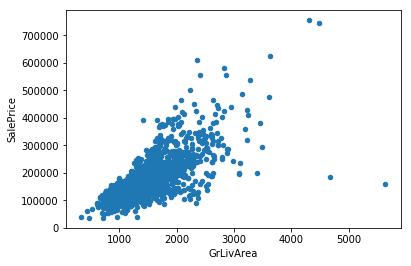

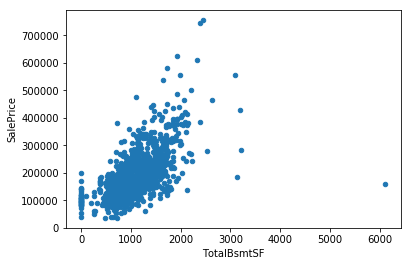

In [11]:
train,test=read_data()
cols=['GrLivArea','TotalBsmtSF']
all_data=concate_data(train,test)
plot_scatter(all_data,cols)


catagorical feat 43
numeric feat 36
continuous feat 21
discrete feat 15


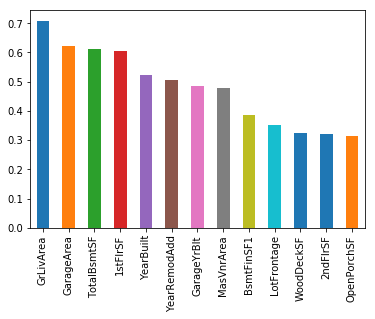

['GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'LotArea', 'BsmtUnfSF', 'EnclosedPorch', 'ScreenPorch', '3SsnPorch', 'LowQualFinSF', 'MiscVal', 'BsmtFinSF2']


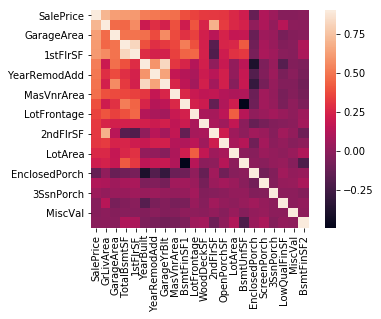

In [12]:
num_feat,cat_feat,con_feat,dis_feat=get_feat_count(all_data)
#plot_scatter(train,all_data,con_feat)
cm,corr_cols=get_corr_list(all_data,con_feat,0.3,enc='none')
cm.drop(['SalePrice'],inplace=True)
cm['corr_value'][cm['corr_value']>0.3].plot.bar()
plt.show()
print(corr_cols)
#sns.pairplot(all_data[corr_cols[:10]])
#plt.show()
plot_heatmap(all_data,corr_cols)

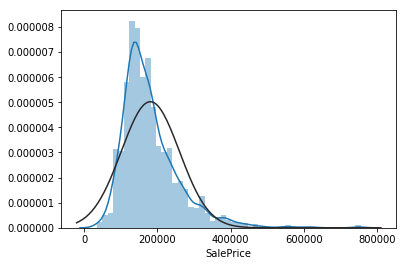

all_data size is: (2919, 79) 
Concating data done ...


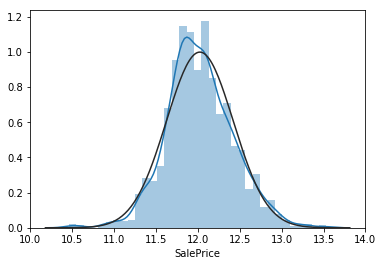

In [13]:
sns.distplot(train.SalePrice,fit=norm)
plt.show()
train=unscew_target(train)
sns.distplot(train.SalePrice,fit=norm)
all_data=concate_data(train,test)
plt.show()

removing oulier done...
all_data size is: (2915, 79) 
Concating data done ...


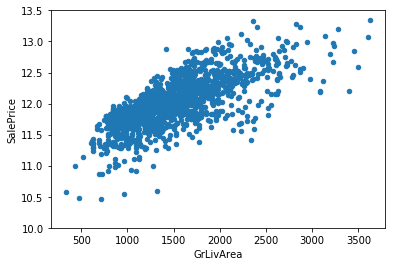

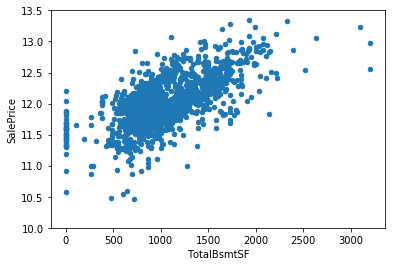

In [14]:
train=remove_outlier(train,norm_target=True)
all_data=concate_data(train,test)
cols=['GrLivArea','TotalBsmtSF']
plot_scatter(all_data,cols)

# Unskewing target feature

In [15]:
def missing_count(all_data):
    all_data_na = (all_data.isnull().sum()/ len(all_data)) * 100
    all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index)
    all_data_na=all_data_na.sort_values(ascending = False)
    missing_data =pd.DataFrame({'Miss_ratio':all_data_na[all_data_na>0.0]})
    miss_cols=list(missing_data.index)
    num_feat,cat_feat,con_feat,dis_feat=get_feat_count(all_data)
    i=0
    m_cat_feat=[]
    m_con_feat=[]
    m_dis_feat=[]
    m_all=[]
    for col in miss_cols:
        if col in cat_feat:
            m_cat_feat.append(col)
            m_all.append('catagorical')
        if col in con_feat:
            m_con_feat.append(col)
            m_all.append('continuous')
        if col in dis_feat:
            m_dis_feat.append(col)
            m_all.append('discrete')
        i=i+1
    missing_data['type']=m_all    
    return missing_data,m_cat_feat,m_con_feat,m_dis_feat

catagorical feat 43
numeric feat 36
continuous feat 21
discrete feat 15
catagorical feat 43
numeric feat 36
continuous feat 21
discrete feat 15


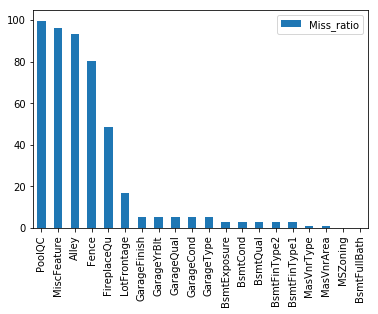

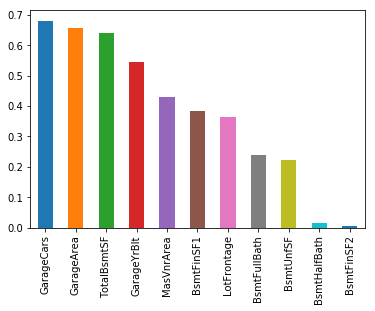

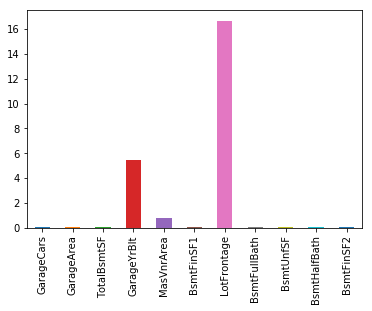

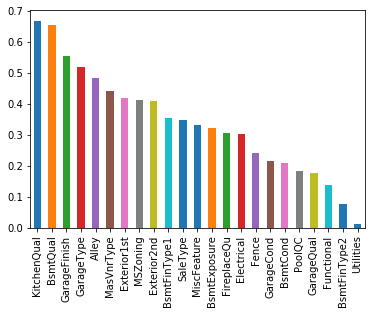

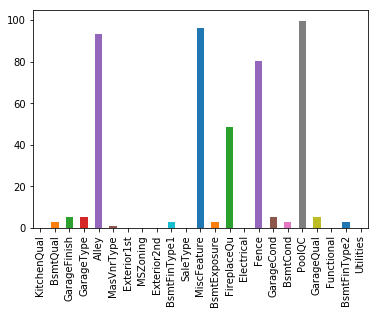

In [16]:
num_feat,cat_feat,con_feat,dis_feat=get_feat_count(all_data)
miss_data,m_cat_cols,m_con_cols,m_dis_cols=missing_count(all_data)
miss_data[:20].plot.bar()
plt.show()


cm,corr_feat=get_corr_list(all_data,m_con_cols+m_dis_cols,thr=0,enc='none')
cm['miss_ratio']=0
for feat in corr_feat:
    cm.loc[feat,'miss_ratio']=miss_data.loc[feat,'Miss_ratio']
cm.drop(['SalePrice'],inplace=True)
cm['corr_value'].plot.bar()
plt.show()
cm['miss_ratio'].plot.bar()
plt.show()


cm,corr_feat=get_corr_list(all_data,m_cat_cols,thr=0.0,enc='ord_enc')
cm['miss_ratio']=0
for feat in corr_feat:
    cm.loc[feat,'miss_ratio']=miss_data.loc[feat,'Miss_ratio']
cm.drop(['SalePrice'],inplace=True)
cm['corr_value'].plot.bar()
plt.show()
cm['miss_ratio'].plot.bar()
plt.show()

#all_data=handle_missing_values_new(all_data,m_cat_cols,m_con_cols,m_dis_cols)

In [17]:

def handle_missing_values_new(data,m_cat_cols,m_con_cols,m_dis_cols):
    #Some catagorical colums
    mode_cols=['MSZoning','KitchenQual','Exterior1st','Exterior2nd','SaleType','Electrical']
    for col in mode_cols:
        data[col] = data[col].fillna(data[col].mode()[0])

    
    
    #group by Neigborhood and fill missing value with median Lot frontage of all the neighboorhood
    data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
    data['GarageYrBlt'].fillna(0)
    data['GarageYrBlt_NA'] =np.array(data['GarageYrBlt']>0)
    #add total surface area as TotalSf = basement + firstflr + secondflr
    zero_cols=['TotalBsmtSF','1stFlrSF','2ndFlrSF']
    
    
    for col in zero_cols:
        data[col] = data[col].fillna(0)
    data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
    
    for col in m_cat_cols:
        data[col] = data[col].fillna('None')
    for col in m_con_cols:
        data[col] = data[col].fillna(0)
    for col in m_dis_cols:
        data[col]=data[col].fillna(0)
    print('Missing values handling done ...')
    return data

all_data=handle_missing_values_new(all_data,m_cat_cols,m_con_cols,m_dis_cols)

Missing values handling done ...


In [18]:

#all_data=impute_rare(all_data,cat_feat,min_occ=5)
#all_data=ordinal_encode(all_data,cat_feat)
#all_data=handle_missing_values(all_data)
#cm,corr_feat=get_corr_list(all_data,con_feat+dis_feat,thr=0.6,enc='_enc')
#all_data=ordinal_encode(all_data,corr_feat)
#all_data=label_encode(all_data,corr_feat)
#len(all_data[num_feat[1]].unique())

In [19]:
def get_skewness(all_data,feat):
    skewed_features = all_data[feat].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)
    print ("Skewness : \n")
    skewness = pd.DataFrame({'Skew' :skewed_features})   
    skewness.head(5)    
    return skewness
def unscew_features(skewness,all_data,thr=.75):
    skewness = skewness[abs(skewness) > 0.75]
    print ("There are {} skewed numerical features to box cox transform".format(skewness.shape[0]))

    from scipy.special import boxcox1p 
    skewed_features = skewness.index
    lam = 0.15
    for feat in skewed_features:
        all_data[feat] = boxcox1p(all_data[feat], lam)
    #all_data.drop(['Exterior2nd'],axis=1,inplace=True)
    return all_data

catagorical feat 43
numeric feat 38
continuous feat 22
discrete feat 16
Skewness : 



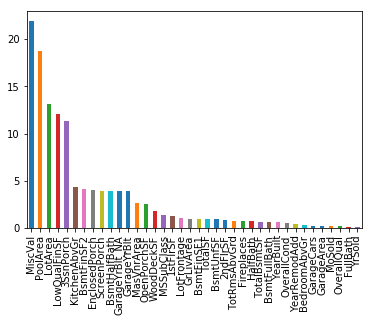

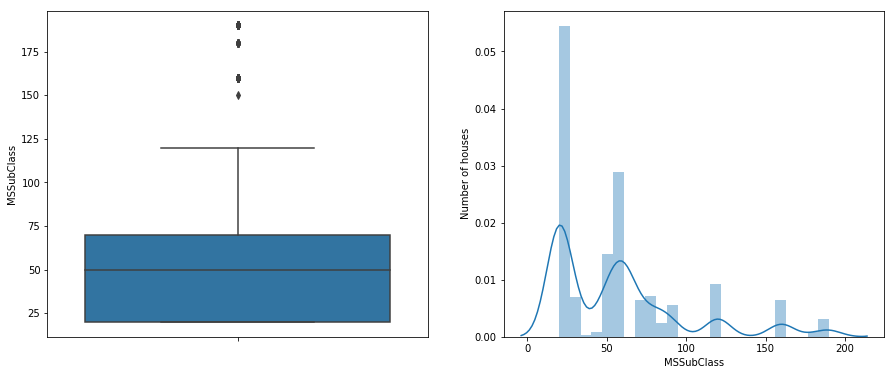

Mean skewness Skew    3.348002
dtype: float64
There are 38 skewed numerical features to box cox transform
Skewness : 



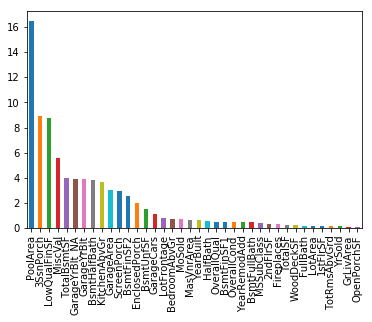

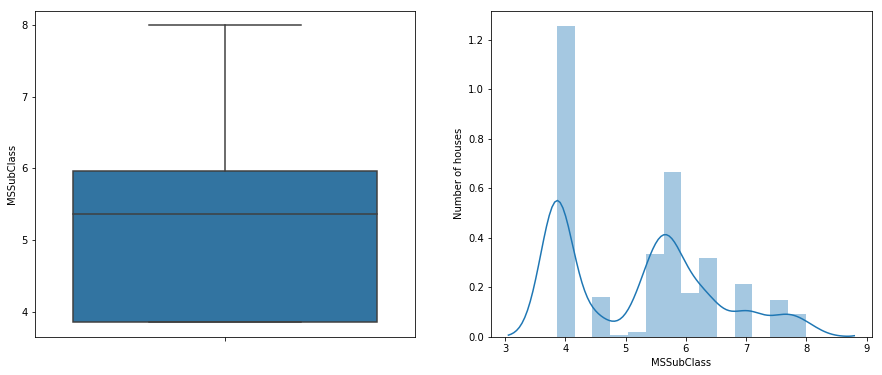

Mean Skewness Skew    2.137742
dtype: float64


In [20]:
data=all_data.copy()
num_feat,cat_feat,con_feat,dis_feat=get_feat_count(data)
skewness=get_skewness(data,num_feat)
skewness=pd.DataFrame(skewness)
skewness['Skew']=skewness['Skew'].abs()
skewness.sort_values(by='Skew',ascending=False,inplace=True)
skewness['Skew'].plot.bar()
plt.show()
feat=skewness.index[0:1]
plot_scewness(data,num_feat[0:1])
print('Mean skewness',skewness.mean())

data=unscew_features(skewness,data,thr=.75)

skewness=get_skewness(data,num_feat)
skewness=pd.DataFrame(skewness)
skewness['Skew']=skewness['Skew'].abs()
skewness.sort_values(by='Skew',ascending=False,inplace=True)
skewness['Skew'].plot.bar()
plt.show()
plot_scewness(data,num_feat[0:1])
feat=skewness.index[0]
print('Mean Skewness',skewness.mean())
#sns.distplot(data[feat],fit=norm)

In [21]:
sc_data=data.copy()
print(sc_data.shape)
sc_data.replace(np.nan,0,inplace=True)
sc_data.replace(np.inf,0,inplace=True)
sc_data=sc_data.fillna(0)
sc_data = pd.get_dummies(sc_data)    
robust_scaler = RobustScaler()
_all_data = robust_scaler.fit(sc_data).transform(sc_data)

(2915, 81)


In [22]:
num_feat,cat_feat,con_feat,dis_feat=get_feat_count(all_data)


catagorical feat 43
numeric feat 38
continuous feat 22
discrete feat 16


In [23]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train= train.SalePrice.values
_train = pd.DataFrame(_all_data[:ntrain])
_test = pd.DataFrame(_all_data[ntrain:])

In [24]:
# Create linear regression object
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
#regr = linear_model.LinearRegression()
regr=linear_model.Ridge(alpha=8)
regr.fit(_train.values,y_train)
#test.loc[133,cols[160:170]]=test.loc[134,cols[160:170]]
res=regr.predict(np.array(_test.values))


In [25]:
score1=cross_val_score(regr, _train.values, y_train, scoring="neg_mean_squared_error",cv = 10)
score2=cross_val_score(regr, _train.values, y_train, scoring="r2",cv = 10)
print(score1.mean(),score1.std())
print(score2.mean(),score1.std())

#-0.012369057618423041 0.0032126410083447177
#0.9213673151092987 0.0032126410083447177
#missing value
#-0.012313903066315813 0.003235203354700795
#0.9216997086256249 0.003235203354700795
# no_missing+no_scew
#-0.012893640537486937 0.0033568391846368604
#0.9181741085106214 0.0033568391846368604
# no_scew
#-0.012860057976691939 0.003367599186540071
#0.9183571335967585 0.003367599186540071
#all_done
#-0.012313903066315813 0.003235203354700795
#0.9216997086256249 0.003235203354700795
#no_robust_scaling
#-0.012664039962787466 0.0032548345260856437
#0.9194309845515554 0.0032548345260856437


-0.012313903066315813 0.003235203354700795
0.9216997086256249 0.003235203354700795


In [26]:
'''
-0.012921073887923098 0.003337743599841044
0.9179613688980304 0.003337743599841044
#missin_value
-0.012885682366430447 0.0033508592812045877
0.918160340886842 0.0033508592812045877
#scewing
-0.012664039962787466 0.0032548345260856437
0.9194309845515554 0.0032548345260856437
#robust_scaling
-0.012313903066315813 0.003235203354700795
0.9216997086256249 0.003235203354700795
'''

'\n-0.012921073887923098 0.003337743599841044\n0.9179613688980304 0.003337743599841044\n#missin_value\n-0.012885682366430447 0.0033508592812045877\n0.918160340886842 0.0033508592812045877\n#scewing\n-0.012664039962787466 0.0032548345260856437\n0.9194309845515554 0.0032548345260856437\n#robust_scaling\n-0.012313903066315813 0.003235203354700795\n0.9216997086256249 0.003235203354700795\n'

In [27]:
rres_exp=np.exp(res)
print(len(rres_exp))
data='Id,SalePrice\n'
Id=1461
for row in rres_exp:
    data+=str(Id)+','+str(row)+'\n'
    Id+=1
file=open('sub14_Linear Regression_one_hot_ridge V-7.0.csv','w')
file.write(data)
file.close()

1459


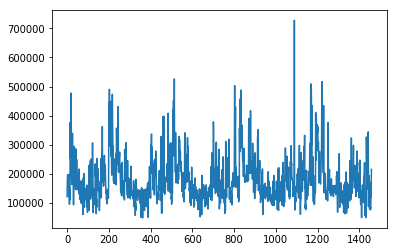

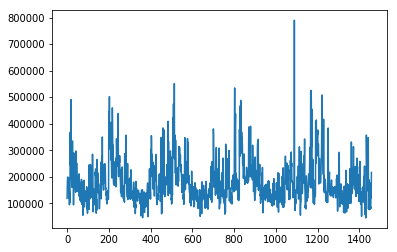

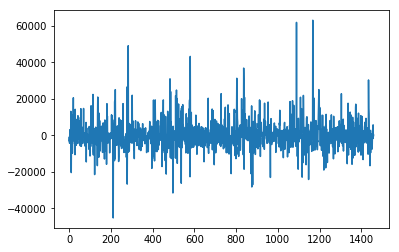

0.0015237401456063592


In [28]:
test_check=pd.read_csv('submission.csv')
c_res=test_check['SalePrice']
plt.plot(c_res)
plt.show()
plt.plot(rres_exp)
plt.show()
plt.plot(rres_exp-c_res)
plt.show()
er=mean_squared_error(np.log(rres_exp),np.log(c_res))
print(er)

In [29]:
'''
SalePrice        1.000000
ExterQual        0.584138
BsmtQual         0.574916
KitchenQual      0.530470
GarageType       0.504519
HeatingQC        0.425864
GarageFinish     0.414554
Foundation       0.412103
CentralAir       0.353707
GarageCond       0.325360
PavedDrive       0.306194
BsmtExposure     0.299405
Electrical       0.295738
GarageQual       0.276776
LotShape         0.273934
SaleCondition    0.260785
HouseStyle       0.211675
Neighborhood     0.201530
MSZoning         0.190488
RoofStyle        0.185602
ExterCond        0.148117
Fence            0.143320
Heating          0.140651
Exterior2nd      0.13322
'''
'''
SalePrice        1.000000
Neighborhood     0.742644
ExterQual        0.680947
KitchenQual      0.667174
BsmtQual         0.647231
GarageFinish     0.604917
GarageType       0.578402
Foundation       0.550950
FireplaceQu      0.547226
HeatingQC        0.474218
MasVnrType       0.435812
Exterior1st      0.415804
MSZoning         0.412798
Exterior2nd      0.402421
BsmtFinType1     0.395803
GarageCond       0.379780
GarageQual       0.360675
CentralAir       0.353707
BsmtExposure     0.353555
'''


'\nSalePrice        1.000000\nNeighborhood     0.742644\nExterQual        0.680947\nKitchenQual      0.667174\nBsmtQual         0.647231\nGarageFinish     0.604917\nGarageType       0.578402\nFoundation       0.550950\nFireplaceQu      0.547226\nHeatingQC        0.474218\nMasVnrType       0.435812\nExterior1st      0.415804\nMSZoning         0.412798\nExterior2nd      0.402421\nBsmtFinType1     0.395803\nGarageCond       0.379780\nGarageQual       0.360675\nCentralAir       0.353707\nBsmtExposure     0.353555\n'

In [30]:
all_col=m_cat_cols+m_con_cols+m_dis_cols
zero_cols=['GarageYrBlt','GarageArea', 'GarageCars','BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF',
               'TotalBsmtSF','BsmtFullBath','BsmtHalfBath','MasVnrArea']
mode_cols=['MSZoning','Electrical','KitchenQual','Exterior1st','Exterior2nd','SaleType']
for col in zero_cols:
    if col in m_con_cols:
        print(col)

GarageYrBlt
GarageArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
MasVnrArea
